In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygments.lexers import j
import datetime
from sklearn.neighbors import KernelDensity
from scipy import stats
import KDEpy


In [2]:
## test this - then add catigorical variables
class veeringPhase_frame:
    ## pandas data from to recieve phases from SQL RRP.
    ## frame is then processed to bin variables, define categorical variables
    def __init__(self,rawFrame):
        self.frame = rawFrame.dropna()
        
    def Rename_Columns(self):
        self.frame = self.frame.rename(columns={'BSPpol%':'BSPpolPerc', 'VMG%':'VMGperc', 'BSP_trg%':'BSP_trgPerc'})
        
    def Add_Date_column(self):
        self.frame['Date'] = self.frame['StartTime'].apply(lambda x: x.date())

    def CheckSigns(self,vars):
        for var in vars:
            self.frame[var] = abs(self.frame[var])

    def DefineBins(self,min_max_step):
        ## function takes a list [min, max, step] and defines the bin edges and labels
        min, max, step = min_max_step[0], min_max_step[1]+1, min_max_step[2]
        centres = list(np.arange(min,max,step))
        min = min - (0.5*step)
        max = max + (0.5*step)
        edges = list(np.arange(min,max,step))
        return centres, edges

        
    def Create_Bin_Variables(self,binVars):
        ## function takes a list of variables [varName, newVarName, [min,max,step] and creates a binned variable
        self.binVars = binVars
        for var in self.binVars:
            centres, edges = self.DefineBins(var[2])
            self.frame[var[1]] = pd.cut(self.frame[var[0]], bins=edges, labels=centres)
            
    def Create_Categorical_Variables(self,catVars, cat_threshold):
        ## function changes defined variables to a categorical type and removes categories where the count is < threshold
        self.catVars = catVars
        self.cat_threshold = cat_threshold
        for var in self.catVars:
            self.frame[var] = self.frame[var].astype('category')
            catCount = self.frame.groupby(var,observed=False).size()
            catCount = catCount/sum(catCount)
            drop = catCount[catCount < self.cat_threshold].index
            self.frame[var] = self.frame[var].cat.remove_categories(drop)
    
    def Add_TWS_Weights(self, weights):
        ## add TWS weights to create "equivelant race"
        self.frame = self.frame.merge(weights, left_on='TWS_bin', right_index=True)
        
    def Filter_Sailing_Mode(self,Mode):
        self.frame = self.frame.loc[(self.frame.SailingMode == Mode)]
        
class veeringDay_frame:
    def __init__(self,frame):
        self.frame = frame
        
    def Filter_Date(self,date_list):
        ## Filter data frame by date to create the "day frame"
        self.year = date_list[0]
        self.month = date_list[1]
        self.day = date_list[2]
        self.dayFrame = self.frame.loc[self.frame.Date == datetime.date(year=self.year,month=self.month,day=self.day)]
        
    def Filter_Race(self,raceNo):
        self.raceFrame = self.dayFrame.loc[(self.frame.RaceNum == raceNo)]

    def Get_TWS_bin_weights(self,level):
        ## Calculate the TWS bin weights for creating an equivelant race or day
        if level == 'day':
            twsBin_weights = self.dayFrame.groupby('TWS_bin',observed=False).size()/self.dayFrame.groupby('TWS_bin',observed=False).size().sum()
            twsBin_weights = pd.DataFrame(twsBin_weights, columns=['TWS_bin_weight'])
        elif level == 'race':
            twsBin_weights = self.raceFrame.groupby('TWS_bin',observed=False).size()/self.raceFrame.groupby('TWS_bin',observed=False).size().sum()
            twsBin_weights = pd.DataFrame(twsBin_weights, columns=['TWS_bin_weight'])  
        
        return twsBin_weights
        
        

In [3]:
config = {'username':'flyingjennysql',
          'password':'Cape31rrp!',
          'host':'veeringq.ddns.net',
          'port':'3306',
          'database':'flyingjenny'
          }
cnx = mysql.connector.connect(**config)

phasesFrame = veeringPhase_frame(pd.read_sql_query('SELECT StartTime, SailingMode, RaceNum, TWS, TWA, BSP, HEEL, RUDDER, `BSPpol%`, `VMG%`, `BSP_trg%`, BSP_trg, TWA_trg, AWA, FORESTAY, Chock, D1, D2, V1, Headstay, Mainsail, Headsail, Spinnaker FROM t_phase WHERE `VMG%`>50', cnx))

cnx.close()

/var/folders/b5/1kkh0fjj6cqg5n9rk3j623dr0000gn/T/ipykernel_19456/548791299.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  phasesFrame = veeringPhase_frame(pd.read_sql_query('SELECT StartTime, SailingMode, RaceNum, TWS, TWA, BSP, HEEL, RUDDER, `BSPpol%`, `VMG%`, `BSP_trg%`, BSP_trg, TWA_trg, AWA, FORESTAY, Chock, D1, D2, V1, Headstay, Mainsail, Headsail, Spinnaker FROM t_phase WHERE `VMG%`>50', cnx))


In [4]:
mode = 1

checkSignVars = ['TWA']

categoricalVars = ['SailingMode',
                        'RaceNum',
                        'Chock', 
                        'D1',
                        'D2',
                        'V1',
                        'Headstay',
                        'Mainsail',
                        'Headsail',
                        'Spinnaker']

binVars = [['TWS', 'TWS_bin',[1, 30, 2]],
           ['TWA', 'TWA_bin', [20, 165, 1]],
           ['HEEL', 'HEEL_bin', [0, 25, 1]],
           ['RUDDER', 'RUDDER_bin', [-1.6, 3.6, 0.2]],
           ['FORESTAY', 'FORESTAY_bin', [0.2, 2.2, 0.1]],
           ['BSP', 'BSP_bin', [3, 20, 0.1]],
           ['AWA', 'AWA_bin', [10, 150, 1]]]

date = [2023,6,9]

raceNo = 3


In [5]:
phasesFrame.Filter_Sailing_Mode(mode)
phasesFrame.Add_Date_column()
phasesFrame.Rename_Columns()
phasesFrame.CheckSigns(checkSignVars)
phasesFrame.Create_Categorical_Variables(categoricalVars,0.01)
phasesFrame.Create_Bin_Variables(binVars)
dayFrame = veeringDay_frame(phasesFrame.frame)
dayFrame.Filter_Date(date)
dayFrame.Filter_Race(raceNo)
phasesFrame.Add_TWS_Weights(dayFrame.Get_TWS_bin_weights(level='day'))





(array([ 1.,  0.,  6.,  0.,  0., 14.,  0., 16.,  0.,  5.]),
 array([ 9. ,  9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. ]),
 <BarContainer object of 10 artists>)

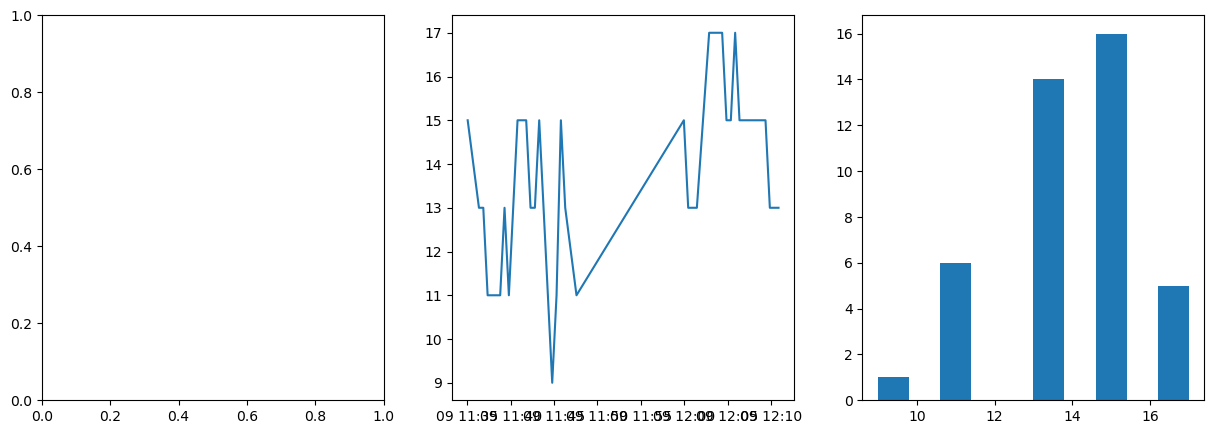

In [6]:
tws_plots, axes = plt.subplots(1,3,figsize=(15,5))
axes[1].plot(dayFrame.raceFrame['StartTime'], dayFrame.raceFrame['TWS_bin'])
axes[2].hist(dayFrame.raceFrame['TWS_bin'])

In [7]:
X = np.asarray(phasesFrame.frame['VMGperc'])[:, np.newaxis]
X_weights = np.asarray(phasesFrame.frame['TWS_bin_weight'])[:, np.newaxis]
X_day = np.asarray(dayFrame.frame['VMGperc'])[:, np.newaxis]
kernel = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X)
x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
x1,y1 = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X, weights=X_weights).evaluate()
x2,y2 = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X_day).evaluate()

In [8]:
plot_granularity = ['eq','day']
filter_threshold = 0.1
lowest = plot_granularity[-1]
x_all = []
y_all = []
x_wind_low = []
x_wind_high = []
y_wind_low = []
y_wind_high = []
label_wind = []
label_all = []
for granularity in plot_granularity:
    if granularity == 'all':
        X = np.asarray(phasesFrame.frame['VMGperc'])[:, np.newaxis]
        X_weights = np.ones_like(X)
        label = 'All'
    elif granularity == 'eq':
        X = np.asarray(phasesFrame.frame['VMGperc'])[:, np.newaxis]
        X_weights = np.asarray(phasesFrame.frame['TWS_bin_weight'])[:, np.newaxis]
        label = 'Equivalent'
    elif granularity == 'day':
        X = np.asarray(dayFrame.dayFrame['VMGperc'])[:, np.newaxis]
        X_weights = np.ones_like(X)
        label = 'Day'
    elif granularity == 'race':
        X = np.asarray(dayFrame.raceFrame['VMGperc'])[:, np.newaxis]
        X_weights = np.ones_like(X)
        label = 'Race'
    try:
        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X,weights=X_weights).evaluate()
        x_all.append(x)
        y_all.append(y)
        label_all.append(label)
    except:
        print(granularity)
    
    if granularity == lowest:
        windFrame = []
        if lowest == 'race':
            windFrame = dayFrame.raceFrame
        elif lowest == 'day':
            windFrame = dayFrame.dayFrame
        else:
            break

        filter = (windFrame.groupby('TWS_bin',observed=False).size()/windFrame.groupby('TWS_bin',observed=False).size().sum())
        for i in filter[filter > filter_threshold].index:
            try:
                X = np.asarray(windFrame.loc[windFrame['TWS_bin']==i, 'VMGperc'])[:, np.newaxis]
                x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
                x_wind_low.append(x)
                y_wind_low.append(y)
                label_wind.append(i)
                X = np.asarray(phasesFrame.frame.loc[phasesFrame.frame['TWS_bin']==i, 'VMGperc'])[:, np.newaxis]
                x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
                x_wind_high.append(x)
                y_wind_high.append(y)
            except:
                print(i)


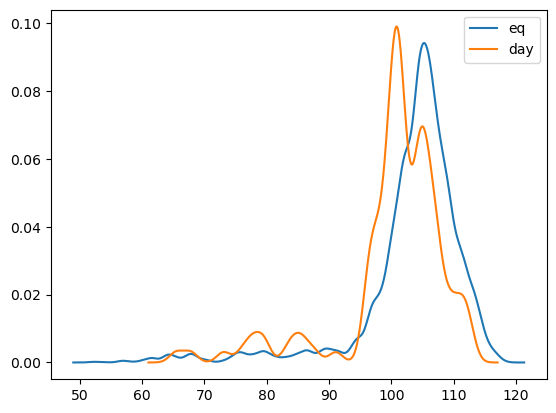

In [9]:

for i in range(len(plot_granularity)):
    plt.plot(x_all[i], y_all[i], label=plot_granularity[i])
    plt.legend()

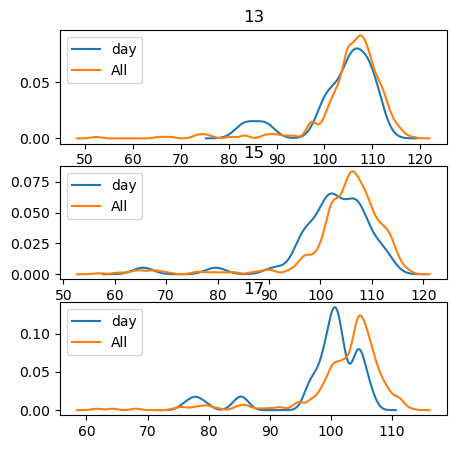

In [10]:

vmgBreakdown_plot, axes = plt.subplots(len(label_wind),1,figsize=(5,5))
for i in range(len(label_wind)):
    axes[i].plot(x_wind_low[i], y_wind_low[i], label=lowest)
    axes[i].plot(x_wind_high[i], y_wind_high[i], label='All')
    axes[i].legend()
    axes[i].set_title(label_wind[i])

In [11]:
metric = 'BSP'

metrics_dict = {'BSP':['BSP_bin','BSP_trg','BSP_trgPerc']}

lowest = plot_granularity[-1]
x_all = []
y_all = []


label_all = []
for frameMetric in [metric, metrics_dict[metric][1]]:
    label = frameMetric
    if frameMetric == metric:
        if lowest == 'day':
            X = np.asarray(dayFrame.dayFrame[frameMetric])[:, np.newaxis]
            X_weights = np.ones_like(X)
            
        elif lowest == 'race':
            X = np.asarray(dayFrame.raceFrame[frameMetric])[:, np.newaxis]
            X_weights = np.ones_like(X)
    
    else:
        X = np.asarray(phasesFrame.frame[frameMetric])[:, np.newaxis]
        X_weights = np.asarray(phasesFrame.frame['TWS_bin_weight'])[:, np.newaxis]
    
    try:
        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X,weights=X_weights).evaluate()
        x_all.append(x)
        y_all.append(y)
        label_all.append(label)
    except:
        print(frameMetric)



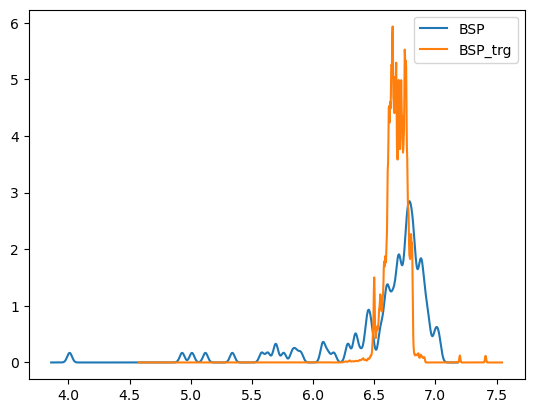

In [12]:
for i in range(len(label_all)):
    plt.plot(x_all[i], y_all[i], label=label_all[i])
    plt.legend()

In [22]:
def AvgTRG_To_TRGbin(AVGtrg,bins):
    dif = np.abs(np.asarray(bins)-AVGtrg)
    binInd = np.where(dif == dif.min())[0][0]
    bin = np.asarray(bins)[binInd]
    return bin

x_wind_low_trgPerc = []
x_wind_high_trgPerc = []
x_wind_low_vmg = []
x_wind_high_vmg = []
x_wind_target_vmg = []
y_wind_low_trgPerc = []
y_wind_high_trgPerc = []
y_wind_low_vmg = []
y_wind_high_vmg = []
y_wind_target_vmg = []
centres_wind = []
label_wind_trgPerc = []
label_wind_vmg = []


if lowest == 'race':
    windFrame = dayFrame.raceFrame
elif lowest == 'day':
    windFrame = dayFrame.dayFrame

filter = (windFrame.groupby('TWS_bin',observed=False).size()/windFrame.groupby('TWS_bin',observed=False).size().sum())

for i in filter[filter > filter_threshold].index:
#for i in [13]:
    if lowest == 'race':
        windFrame = dayFrame.raceFrame
    elif lowest == 'day':
        windFrame = dayFrame.dayFrame
    ## reduce wind frame to TWS bin of interest
    windFrame = windFrame.loc[windFrame['TWS_bin']==i,[metric, metrics_dict[metric][0],metrics_dict[metric][1],metrics_dict[metric][2],'VMGperc']].dropna()
    ## reduce phases frame to TWS bin of interest
    highFrame = phasesFrame.frame
    highFrame = highFrame.loc[highFrame['TWS_bin']==i,[metric, metrics_dict[metric][0],metrics_dict[metric][1],metrics_dict[metric][2],'VMGperc']].dropna()
    
    try:
        ## create series of target percents for wind bin and low granularity and fit KDE
        X = np.asarray(windFrame[metrics_dict[metric][2]])[:, np.newaxis]
        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
        x_wind_low_trgPerc.append(x)
        y_wind_low_trgPerc.append(y)
        ## create series of target percents for wind and high granularity and fit KDE
        X = np.asarray(highFrame[metrics_dict[metric][2]])[:, np.newaxis]
        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
        x_wind_high_trgPerc.append(x)
        y_wind_high_trgPerc.append(y)

        ## Calculate centres [target, mean, median, mode]
        ## create series of observed values
        X = np.asarray(windFrame[metrics_dict[metric][0]])[:, np.newaxis]
        ## calculate the average target observed
        trgMean = np.asarray(windFrame[metrics_dict[metric][1]]).mean()

        centeres = []
        ## iterate over all centres and match with the closest bin
        for centre in [trgMean, X.mean(),np.median(X),stats.mode(X)[0][0]]:
            #cent = AvgTRG_To_TRGbin(centre,phasesFrame.frame.loc[phasesFrame.frame['TWS_bin']==i][metrics_dict[metric][0]])
            cent = AvgTRG_To_TRGbin(centre,highFrame[metrics_dict[metric][0]])
            centeres.append(cent)
        centres_wind.append(centeres)
        
        ## create KDE for VMG perc
        label_vmg = []

        try:
            ## create series of VMG perc for all phases @ target
            X = np.asarray(highFrame.loc[highFrame[metrics_dict[metric][0]] == centeres[0],'VMGperc'])[:, np.newaxis]
            x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
            x_wind_high_vmg.append(x)
            y_wind_high_vmg.append(y)
            label_vmg.append('VMG All @ TRG')
            print(str(i)+"TWS - VMG All @ TRG - Bin Size = "+str(len(X)))
        except:
            x_wind_high_vmg.append([])
            y_wind_high_vmg.append([])
            label_vmg.append('VMG All @ TRG')
            print(str(i)+"TWS - FAIL - VMG All @ TRG - Bin Size = "+str(len(X)))

        try:
            ## create series of VMG perc for low granularity @ target
            X = np.asarray(windFrame.loc[windFrame[metrics_dict[metric][0]] == centeres[0],'VMGperc'])[:, np.newaxis]
            x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
            x_wind_target_vmg.append(x)
            y_wind_target_vmg.append(y)
            label_vmg.append('VMG RACE @ TRG')
            print(str(i)+"TWS - VMG RACE @ TRG - Bin Size = "+str(len(X)))
        except:
            x_wind_target_vmg.append([])
            y_wind_target_vmg.append([])
            label_vmg.append('VMG RACE @ TRG')
            print(str(i)+"TWS - FAIL - VMG RACE @ TRG - Bin Size = "+str(len(X)))

        try:
            ## create series of VMG perc for low granularity @ mode
            X = np.asarray(windFrame.loc[windFrame[metrics_dict[metric][0]] == centeres[3],'VMGperc'])[:, np.newaxis]
            x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
            x_wind_low_vmg.append(x)
            y_wind_low_vmg.append(y)
            label_vmg.append('VMG RACE @ MODE')
            print(str(i)+"TWS - VMG RACE @ MODE - Bin Size = "+str(len(X)))
        except:
            x_wind_low_vmg.append([])
            y_wind_low_vmg.append([])
            label_vmg.append('VMG RACE @ MODE')
            print(str(i)+"TWS - FAIL - VMG RACE @ MODE - Bin Size = "+str(len(X)))

        label_wind_trgPerc.append(i)
        label_wind_vmg.append(label_vmg)
        
    except:
        print("Fail - Metric = "+str(metric)+" - At TWS =  "+str(i))
    

## add scatter plot option
## add mode/ target matching

 

    


13TWS - VMG All @ TRG - Bin Size = 9
13TWS - FAIL - VMG RACE @ TRG - Bin Size = 3
13TWS - FAIL - VMG RACE @ MODE - Bin Size = 4
15TWS - VMG All @ TRG - Bin Size = 15
15TWS - FAIL - VMG RACE @ TRG - Bin Size = 4
15TWS - VMG RACE @ MODE - Bin Size = 10
17TWS - VMG All @ TRG - Bin Size = 22
17TWS - VMG RACE @ TRG - Bin Size = 14
17TWS - VMG RACE @ MODE - Bin Size = 14


/Users/sean/anaconda3/envs/veeringReports/lib/python3.10/site-packages/KDEpy/bw_selection.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  time = np.power((2 * const * K0 / (N * f)), (2.0 / (3.0 + 2.0 * s)))
/Users/sean/anaconda3/envs/veeringReports/lib/python3.10/site-packages/KDEpy/bw_selection.py:85: RuntimeWarning: divide by zero encountered in power
  t_opt = np.power(2 * N * np.sqrt(np.pi) * f, -2.0 / 5)
/Users/sean/anaconda3/envs/veeringReports/lib/python3.10/site-packages/KDEpy/bw_selection.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  time = np.power((2 * const * K0 / (N * f)), (2.0 / (3.0 + 2.0 * s)))
/Users/sean/anaconda3/envs/veeringReports/lib/python3.10/site-packages/KDEpy/bw_selection.py:85: RuntimeWarning: divide by zero encountered in power
  t_opt = np.power(2 * N * np.sqrt(np.pi) * f, -2.0 / 5)


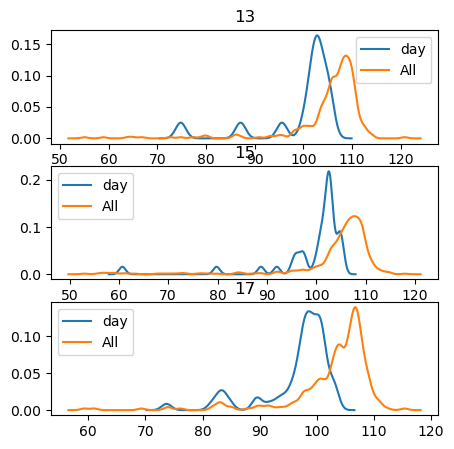

In [23]:
trgBreakdownPlot, axes = plt.subplots(len(label_wind_trgPerc),1,figsize=(5,5))
for i in range(len(label_wind_trgPerc)):
    axes[i].plot(x_wind_low_trgPerc[i], y_wind_low_trgPerc[i], label=lowest)
    axes[i].plot(x_wind_high_trgPerc[i], y_wind_high_trgPerc[i], label='All')
    axes[i].legend()
    axes[i].set_title(label_wind_trgPerc[i])

0
1
2


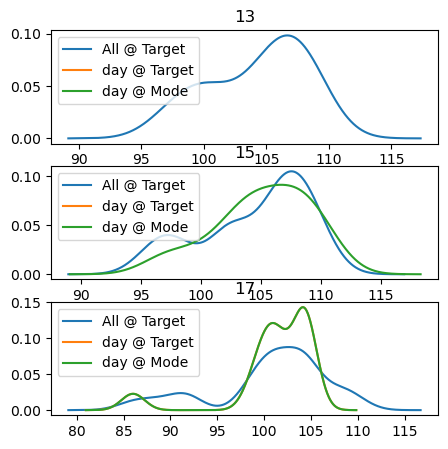

In [29]:
trgBreakdownPlot_vmg, axes = plt.subplots(len(label_wind_trgPerc),1,figsize=(5,5))
for i in range(len(label_wind_trgPerc)):
    print(i)
    axes[i].plot(x_wind_high_vmg[i], y_wind_high_vmg[i], label="All @ Target")
    axes[i].plot(x_wind_target_vmg[i], y_wind_target_vmg[i], label=str(lowest)+" @ Target")
    axes[i].plot(x_wind_low_vmg[i], y_wind_low_vmg[i], label=str(lowest)+" @ Mode")
    axes[i].legend()
    axes[i].set_title(label_wind_trgPerc[i])


In [26]:
plt.plot(x_wind_high_vmg[2],y_wind_high_vmg[2]

array([ 79.09313865,  79.12990671,  79.16667477, ..., 116.63332523,
       116.67009329, 116.70686135])

In [27]:
x_wind_target_vmg[2]

array([ 80.9630527 ,  80.99127742,  81.01950215, ..., 109.78049785,
       109.80872258, 109.8369473 ])

In [28]:
x_wind_low_vmg[2]

array([ 80.9630527 ,  80.99127742,  81.01950215, ..., 109.78049785,
       109.80872258, 109.8369473 ])

y_wind_low_vmg[2]

In [29]:
highFrame = phasesFrame.frame
i = 13
highFrame = highFrame.loc[highFrame['TWS_bin']==i,[metric, metrics_dict[metric][0],metrics_dict[metric][1],metrics_dict[metric][2]]].dropna()
highFrame

,BSP,BSP_bin,BSP_trg,BSP_trgPerc
14,4.93,4.9,6.60,74.8
16,6.82,6.8,6.58,103.6
17,6.72,6.7,6.55,102.5
20,6.89,6.9,6.56,105.0
22,6.91,6.9,6.58,105.1
...,...,...,...,...
2890,7.29,7.3,6.54,111.5
2892,7.14,7.1,6.54,109.1
2948,6.45,6.4,6.55,98.5
2961,6.92,6.9,6.54,105.9


In [27]:
phasesFrame.frame

,StartTime,SailingMode,RaceNum,TWS,TWA,BSP,HEEL,RUDDER,BSPpolPerc,VMGperc,...,Spinnaker,Date,TWS_bin,TWA_bin,HEEL_bin,RUDDER_bin,FORESTAY_bin,BSP_bin,AWA_bin,TWS_bin_weight
0,2023-06-09 11:05:09,1,1,14.5,32.3,5.90,16.7,-1.2,102.2,96.5,...,,2023-06-09,15,32,17,-1.2,1.6,5.9,23,0.316667
1,2023-06-09 11:05:39,1,1,14.1,33.5,6.35,17.2,-0.5,106.6,103.0,...,,2023-06-09,15,33,17,-0.4,1.9,6.3,23,0.316667
6,2023-06-09 11:18:13,1,1,16.2,47.9,6.78,11.1,-2.1,87.2,86.0,...,,2023-06-09,17,48,11,NaN,0.8,6.8,34,0.458333
10,2023-06-09 11:26:13,1,1,14.3,28.8,4.01,-0.6,-4.6,84.6,65.5,...,,2023-06-09,15,29,NaN,NaN,1.0,4.0,23,0.316667
11,2023-06-09 11:28:13,1,2,14.3,40.9,6.74,13.3,1.3,101.9,95.9,...,,2023-06-09,15,41,13,1.4,1.7,6.7,28,0.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,2023-10-15 14:57:39,1,4,10.4,40.1,6.95,15.6,0.8,109.5,108.6,...,,2023-10-15,11,40,16,0.8,1.3,6.9,24,0.050000
3024,2023-10-15 14:58:09,1,4,10.1,41.0,6.85,16.3,0.7,107.0,106.2,...,,2023-10-15,11,41,16,0.8,1.2,6.8,25,0.050000
3025,2023-10-15 14:58:39,1,4,9.9,40.2,6.86,16.3,0.8,109.5,108.5,...,,2023-10-15,9,40,16,0.8,1.2,6.9,24,0.008333
3026,2023-10-15 14:59:09,1,4,10.3,39.9,6.97,17.2,0.9,110.9,109.9,...,,2023-10-15,11,40,17,1.0,1.2,7.0,24,0.050000
